In [1]:
from __future__ import print_function

%matplotlib inline

import sys
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os

import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from datetime import timedelta
import math


from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer

from sagemaker import image_uris


/opt/conda/lib/python3.12/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
# set random seeds for reproducibility
np.random.seed(42)
random.seed(42)


In [3]:
sagemaker_session = sagemaker.Session()


In [4]:
s3_bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
s3_bucket_prefix = (
    "deepar-retail-notebook"  # prefix used for all data stored within the bucket
)
default_bucket_prefix = sagemaker.Session().default_bucket_prefix

# If a default bucket prefix is specified, append it to the s3 path
if default_bucket_prefix:
    s3_prefix = f"{default_bucket_prefix}/{s3_bucket_prefix}"
else:
    s3_prefix = s3_bucket_prefix

role = sagemaker.get_execution_role()  # IAM role to use by SageMaker

In [5]:
region = sagemaker_session.boto_region_name

s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)

In [6]:
image_name = sagemaker.image_uris.retrieve("forecasting-deepar", region)


[05/10/25 00:56:44] INFO     Same images used for training and inference. Defaulting to image     ]8;id=234053;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=146316;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=571858;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=91161;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#530\530]8;;\

In [7]:
online_retail_df = pd.read_json('online_retail.json')
online_retail_df


,Description,Date,UnitsSold,RevenuePounds,AveragePricePerUnitPounds
0,12 pencils small tube red spotty,2009-12-01,45,29.90,0.66
1,12 pencils small tube red spotty,2009-12-02,87,61.75,0.71
2,12 pencils small tube red spotty,2009-12-03,34,23.40,0.69
3,12 pencils small tube red spotty,2009-12-04,84,55.25,0.66
4,12 pencils small tube red spotty,2009-12-05,0,0.00,0.65
...,...,...,...,...,...
104933,wood black board ant white finish,2011-12-05,23,177.13,7.70
104934,wood black board ant white finish,2011-12-06,4,31.80,7.95
104935,wood black board ant white finish,2011-12-07,70,484.50,6.92
104936,wood black board ant white finish,2011-12-08,226,1142.34,5.05


In [8]:
clusters = {
    0: [
        "assorted colour bird ornament",
        "colour glass tlight holder hanging",
        "four hook white lovebirds",
        "hanging heart zinc tlight holder",
        "hanging jam jar tlight holder",
        "hanging metal star lantern",
        "ivory hanging decoration heart",
        "love building block word",
        "lovebird hanging decoration white",
        "mini cake stand hanging strawbery",
        "red toadstool led night light",
        "victorian glass hanging tlight",
        "white hanging heart tlight holder",
        "zinc metal heart decoration"
    ],
    1: [
        "baking set 9 piece retrospot",
        "baking set spaceboy design",
        "childs apron spaceboy design",
        "lunchbox with cutlery retrospot",
        "recycling bag retrospot",
        "red retrospot mug",
        "regency cakestand 3 tier",
        "retro spot large milk jug",
        "retro spot small milk jug"
    ],
    2: [
        "bathroom metal sign",
        "chocolate this way metal sign",
        "cook with wine metal sign",
        "gin tonic diet metal sign",
        "hand over the chocolate sign",
        "hot baths metal sign",
        "metal sign take it or leave it",
        "no singing metal sign",
        "pottering in the shed metal sign",
        "toilet metal sign"
    ],
    3: [
        "12 pencils tall tube posy",
        "12 pencils tall tube woodland",
        "6 ribbons rustic charm",
        "memo board retrospot design",
        "paper bunting retro spots",
        "paper chain kit retro spot",
        "retro spot cake stand",
        "ribbon reel spots design",
        "set 12 retro white chalk sticks",
        "set of 72 retro spot paper doilies",
        "white spot red ceramic drawer knob"
    ],
    4: [
        "bag 500g swirly marbles",
        "charlotte bag suki design",
        "jumbo bag baroque black white",
        "jumbo bag pink vintage paisley",
        "jumbo bag scandinavian paisley",
        "jumbo bag spaceboy design",
        "jumbo bag strawberry",
        "jumbo bag toys",
        "jumbo bag woodland animals",
        "jumbo shopper vintage red paisley",
        "jumbo storage bag skulls",
        "red spotty charlotte bag",
        "red spotty shopper bag",
        "rex cashcarry jumbo shopper",
        "strawberry charlotte bag",
        "woodland charlotte bag"
    ],
    5: [
        "blue harmonica in box",
        "cream heart card holder",
        "cream sweetheart mini chest",
        "feltcraft 6 flower friends",
        "feltcraft butterfly hearts",
        "feltcraft cushion owl",
        "large heart measuring spoons",
        "pink blue felt craft trinket box",
        "set of 3 butterfly cookie cutters",
        "set of 3 heart cookie cutters",
        "small glass heart trinket pot",
        "strawberry ceramic trinket box",
        "sweetheart ceramic trinket box"
    ],
    6: [
        "plasters in tin circus parade",
        "plasters in tin skulls",
        "plasters in tin spaceboy",
        "plasters in tin strongman",
        "plasters in tin vintage paisley",
        "plasters in tin woodland animals",
        "wood 2 drawer cabinet white finish",
        "wood black board ant white finish",
        "wood s3 cabinet ant white finish",
        "wooden picture frame white finish"
    ],
    7: [
        "12 pencils small tube red spotty",
        "red spot ceramic drawer knob",
        "red spotty round cake tins",
        "retro spot tea set ceramic 11 pc",
        "set10 pink spotty party candles",
        "set2 red spotty tea towels",
        "set20 red spotty paper napkins",
        "set5 red spotty lid glass bowls",
        "set6 red spotty paper cups",
        "tea bag plate red spotty"
    ],
    8: [
        "antique silver tea glass etched",
        "natural slate chalkboard large",
        "natural slate heart chalkboard",
        "natural slate rectangle chalkboard",
        "white wood garden plant ladder",
        "wooden frame antique white",
        "wooden happy birthday garland",
        "wooden rounders garden set",
        "wooden school colouring set"
    ],
    9: [
        "60 teatime fairy cake cases",
        "72 sweetheart fairy cake cases",
        "pack of 12 hearts design tissues",
        "pack of 12 woodland tissues",
        "pack of 6 birdy gift tags",
        "pack of 60 dinosaur cake cases",
        "pack of 60 mushroom cake cases",
        "pack of 60 pink paisley cake cases",
        "pack of 60 spaceboy cake cases",
        "pack of 72 retro spot cake cases",
        "pack of 72 skull cake cases",
        "pink fairy cake childs apron",
        "round snack boxes set 4 fruits",
        "round snack boxes set4 woodland"
    ],
    10: [
        "lunch bag black skull",
        "lunch bag cars blue",
        "lunch bag woodland",
        "lunchbag spaceboy design",
        "lunchbag suki design",
        "lunchbox i love london",
        "skull shoulder bag",
        "strawberry lunchbox with cutlery"
    ],
    11: [
        "blue happy birthday bunting",
        "box of 24 cocktail parasols",
        "edwardian parasol natural",
        "fancy font birthday card",
        "party bunting",
        "set of 72 pink heart paper doilies",
        "space boy birthday card",
        "tea party birthday card",
        "vintage heads and tails card game",
        "vintage snap cards",
        "vintage union jack bunting",
        "world war 2 gliders asstd designs"
    ],
    12: [
        "door mat fairy cake",
        "door mat fancy font home sweet home",
        "door mat new england",
        "door mat spotty home sweet home",
        "door mat union flag",
        "doormat hearts"
    ]
}


In [9]:
product_to_cluster = {
    product: cluster_id
    for cluster_id, products in clusters.items()
    for product in products
}

In [10]:
online_retail_df['Cluster'] = online_retail_df['Description'].map(product_to_cluster)
online_retail_df

,Description,Date,UnitsSold,RevenuePounds,AveragePricePerUnitPounds,Cluster
0,12 pencils small tube red spotty,2009-12-01,45,29.90,0.66,7
1,12 pencils small tube red spotty,2009-12-02,87,61.75,0.71,7
2,12 pencils small tube red spotty,2009-12-03,34,23.40,0.69,7
3,12 pencils small tube red spotty,2009-12-04,84,55.25,0.66,7
4,12 pencils small tube red spotty,2009-12-05,0,0.00,0.65,7
...,...,...,...,...,...,...
104933,wood black board ant white finish,2011-12-05,23,177.13,7.70,6
104934,wood black board ant white finish,2011-12-06,4,31.80,7.95,6
104935,wood black board ant white finish,2011-12-07,70,484.50,6.92,6
104936,wood black board ant white finish,2011-12-08,226,1142.34,5.05,6


In [11]:
formatted_df = online_retail_df.rename(columns={
    'Description': 'ProductId'
})
formatted_df = formatted_df.sort_values(['Date', 'ProductId'])
formatted_df = formatted_df[['Date','Cluster', 'ProductId', 'UnitsSold']].reset_index()
formatted_df['UnitsSold'] = formatted_df['UnitsSold'].astype(float)
formatted_df

,index,Date,Cluster,ProductId,UnitsSold
0,0,2009-12-01,7,12 pencils small tube red spotty,45.0
1,739,2009-12-01,3,12 pencils tall tube posy,69.0
2,1478,2009-12-01,3,12 pencils tall tube woodland,4.0
3,2217,2009-12-01,3,6 ribbons rustic charm,27.0
4,2956,2009-12-01,9,60 teatime fairy cake cases,173.0
...,...,...,...,...,...
104933,104198,2011-12-09,8,wooden rounders garden set,0.0
104934,102720,2011-12-09,8,wooden school colouring set,13.0
104935,74638,2011-12-09,4,woodland charlotte bag,40.0
104936,75377,2011-12-09,11,world war 2 gliders asstd designs,49.0


# Cluster 0

In [30]:
cluster_0_df = formatted_df[formatted_df['Cluster'] == 0]
cluster_0_df

,index,Date,Cluster,ProductId,UnitsSold
7,5173,2009-12-01,0,assorted colour bird ornament,1272.0
18,10346,2009-12-01,0,colour glass tlight holder hanging,9.0
33,18475,2009-12-01,0,four hook white lovebirds,13.0
36,20692,2009-12-01,0,hanging heart zinc tlight holder,214.0
37,77595,2009-12-01,0,hanging jam jar tlight holder,0.0
...,...,...,...,...,...
104858,33993,2011-12-09,0,mini cake stand hanging strawbery,56.0
104890,47295,2011-12-09,0,red toadstool led night light,39.0
104920,67248,2011-12-09,0,victorian glass hanging tlight,18.0
104924,70204,2011-12-09,0,white hanging heart tlight holder,4.0


In [31]:
import pandas as pd
import numpy as np
import json

prediction_length = 30
freq = "D"

train_data = []
test_data = []
future_data = []  # ground truth for evaluation later

# Determine global cutoff date
train_end_date = cluster_0_df["Date"].max() - pd.Timedelta(days=prediction_length)

for product_id, group in cluster_0_df.groupby("ProductId"):
    group = group.sort_values("Date")
    target = group["UnitsSold"].tolist()
    target_log = np.log1p(target)

    start_date = group["Date"].iloc[0]
    split_idx = (group["Date"] <= train_end_date).sum()

    if split_idx >= prediction_length:
        # Train record (no future)
        train_data.append({
            "start": str(start_date.date()),
            "target": target_log[:split_idx],
            "item_id": str(product_id)
        })

        # Test record (for prediction — only up to prediction start)
        test_data.append({
            "start": str(start_date.date()),
            "target": target_log[:split_idx],
            "item_id": str(product_id)
        })

        # Store full target (for evaluation after prediction)
        future_data.append({
            "item_id": str(product_id),
            "actual": target_log[split_idx:split_idx + prediction_length].tolist()
        })


In [32]:
import json

# Save train_series
with open("train.json", "w") as f:
    for record in train_series:
        f.write(json.dumps(record) + "\n")

# Save test_series
with open("test.json", "w") as f:
    for record in test_series:
        f.write(json.dumps(record) + "\n")

with open("actual.json", "w") as f:
    for record in future_data:
        f.write(json.dumps(record) + "\n")
        

In [34]:
from sagemaker import image_uris, Session
from sagemaker.estimator import Estimator
import sagemaker
from sagemaker.inputs import TrainingInput


role = sagemaker.get_execution_role()
s3 = boto3.client('s3')
bucket = s3_bucket
prefix = 'deepar-retail2'

s3.upload_file('train.json', bucket, f'{prefix}/train/train.json')
s3.upload_file('test.json', bucket, f'{prefix}/test/test.json')

s3_train_path = f's3://{bucket}/{prefix}/train/'
s3_test_path = f's3://{bucket}/{prefix}/test/'

image_uri = image_uris.retrieve(framework='forecasting-deepar', region=sagemaker_session.boto_region_name)

estimator = Estimator(
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket}/{prefix}/output/',
    sagemaker_session=sagemaker_session
) 

# Set hyperparameters
estimator.set_hyperparameters(
    time_freq='D',
    context_length=365,
    prediction_length=30,
    epochs=100,
    early_stopping_patience=5,
    mini_batch_size=64,
    learning_rate=5e-4,
    num_layers=3,
    num_cells=80,
    likelihood="student-t",
    test_quantiles="[0.1, 0.5, 0.9]"
)

# Launch training job
estimator.fit({
    "train": TrainingInput(s3_train_path, content_type="json"),
    "test": TrainingInput(s3_test_path, content_type="json")
})

[05/10/25 00:26:49] INFO     Same images used for training and inference. Defaulting to image     ]8;id=442417;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=33326;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=529903;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=631262;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=571412;file:///opt/conda/lib/python3.12/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=439898;file:///opt/conda/lib/python3.12/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=6814;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=795667;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#1042\1042]8;;\
                             forecasting-deepar-2025-05-10-00-26-49-245                                            

2025-05-10 00:26:50 Starting - Starting the training job...
2025-05-10 00:27:24 Downloading - Downloading input data......
2025-05-10 00:28:00 Downloading - Downloading the training image..................
2025-05-10 00:31:22 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[05/10/2025 00:31:28 INFO 139661867636544] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likel

In [26]:
import json
import numpy as np
from numpy import array

# Load the test set
data = []
with open("test.json") as f:
    for line in f:
        data.append(json.loads(line))

mape_list = []
smape_list = []
indices = []

prediction_length = 30  # should match your model's setting

for i in range(len(data)):
    series = data[i].copy()
    input_series = {
        "start": series["start"],
        "target": series["target"][:-prediction_length],  # use context window only
    }
    payload = {
        "instances": [input_series],
        "configuration": {
            "num_samples": 100,
            "output_types": ["mean", "quantiles", "samples"],
            "quantiles": ["0.5"]
        }
    }

    serialized_input = json.dumps(payload).encode("utf-8")
    response = predictor.predict(
        serialized_input,
        initial_args={"ContentType": "application/json"}
    )
    result = json.loads(response.decode("utf-8"))
    
    log_forecast = np.array(result["predictions"][0]["quantiles"]["0.5"])
    forecast = np.expm1(log_forecast)
    forecast = np.clip(forecast, 0, None)
    log_actual = series["target"][-prediction_length:]
    actual = np.expm1(log_actual)
    predicted = array(forecast)

    # -- MAPE --
    mask = actual != 0
    if np.any(mask):
        mape = np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100
        mape_list.append(mape)

        # -- SMAPE --
        denominator = (np.abs(actual[mask]) + np.abs(predicted[mask])) / 2
        smape = np.mean(np.abs(predicted[mask] - actual[mask]) / denominator) * 100
        smape_list.append(smape)

        indices.append(i)

# Summary stats
print(f"Mean MAPE: {np.mean(mape_list):.2f}%")
print(f"Mean SMAPE: {np.mean(smape_list):.2f}%")
print(f"MAPE range: {min(mape_list):.2f}% to {max(mape_list):.2f}%")


Mean MAPE: 91.54%
Mean SMAPE: 116.83%
MAPE range: 64.07% to 237.84%


In [24]:
sm = boto3.client('sagemaker')

endpoints = sm.list_endpoints()
for ep in endpoints['Endpoints']:
    print(ep['EndpointName'], ep['EndpointStatus'])

forecasting-deepar-2025-05-10-00-58-00-977 InService
forecasting-deepar-2025-05-10-00-52-27-019 InService
forecasting-deepar-2025-05-10-00-09-52-807 InService
forecasting-deepar-2025-05-09-23-00-02-006 InService
forecasting-deepar-2025-05-09-02-22-19-388 InService
forecasting-deepar-2025-05-08-22-30-50-836 InService
forecasting-deepar-2025-05-08-16-35-12-509 InService
forecasting-deepar-2025-05-08-04-51-38-026 InService


In [25]:
sm.delete_endpoint(EndpointName='forecasting-deepar-2025-05-08-04-51-38-026')


{'ResponseMetadata': {'RequestId': 'a9c56bd5-f888-427f-97d8-63ff7d167c60',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'a9c56bd5-f888-427f-97d8-63ff7d167c60',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 10 May 2025 01:08:10 GMT',
   'content-length': '0'},
  'RetryAttempts': 0}}

In [26]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large"
)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 predictor = estimator.deploy(                                                                │
│   2 │   initial_instance_count=1,                                                                │
│   3 │   instance_type="ml.m5.large"                                                              │
│   4 )                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'estimator' is not defined

In [27]:
max_mape_index = indices[mape_list.index(min(mape_list))]
min_mape_index = indices[mape_list.index(max(mape_list))]
print(min_mape_index)
print(max_mape_index)

10
8


In [27]:
import json
import numpy as np
from numpy import array

# Load test context data (used as input)
with open("test.json") as f:
    test_data = [json.loads(line) for line in f]

# Load true future values (not used in prediction)
with open("actual.json") as f:
    actual_data = [json.loads(line) for line in f]

# Sanity check: match by index/item_id
assert len(test_data) == len(actual_data)

# Prediction settings
prediction_length = 30
mape_list = []
smape_list = []
naive_mape_list = []

for i in range(len(test_data)):
    context_series = test_data[i]
    future_series = actual_data[i]

    # Construct input for SageMaker endpoint
    input_series = {
        "start": context_series["start"],
        "target": context_series["target"]
    }

    payload = {
        "instances": [input_series],
        "configuration": {
            "num_samples": 100,
            "output_types": ["mean", "quantiles", "samples"],
            "quantiles": ["0.5"]
        }
    }

    # Predict
    serialized_input = json.dumps(payload).encode("utf-8")
    response = predictor.predict(
        serialized_input,
        initial_args={"ContentType": "application/json"}
    )
    result = json.loads(response.decode("utf-8"))

    log_forecast = np.array(result["predictions"][0]["quantiles"]["0.5"])
    forecast = np.expm1(log_forecast)
    forecast = np.clip(forecast, 0, None)

    # Actual values
    log_actual = np.array(future_series["actual"])
    actual = np.expm1(log_actual)
    predicted = array(forecast)

    # MAPE
    mask = actual != 0
    if np.any(mask):
        mape = np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100
        mape_list.append(mape)

        # SMAPE
        denominator = (np.abs(actual[mask]) + np.abs(predicted[mask])) / 2
        smape = np.mean(np.abs(predicted[mask] - actual[mask]) / denominator) * 100
        smape_list.append(smape)


# Summary
print(f"Mean MAPE: {np.mean(mape_list):.2f}%")
print(f"Mean SMAPE: {np.mean(smape_list):.2f}%")

print(f"MAPE range: {min(mape_list):.2f}% to {max(mape_list):.2f}%")
print(f"sMAPE range: {min(smape_list):.2f}% to {max(smape_list):.2f}%")


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:43                                                                                   │
│                                                                                                  │
│   40 │                                                                                           │
│   41 │   # Predict                                                                               │
│   42 │   serialized_input = json.dumps(payload).encode("utf-8")                                  │
│ ❱ 43 │   response = predictor.predict(                                                           │
│   44 │   │   serialized_input,                                                                   │
│   45 │   │   initial_args={"ContentType": "application/json"}                                    │
│   46 │   )                                                                                       │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'NoneType' object has no attribute 'predict'

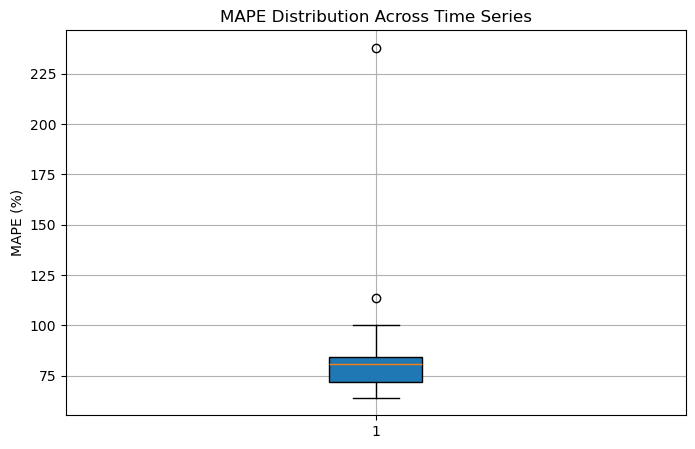

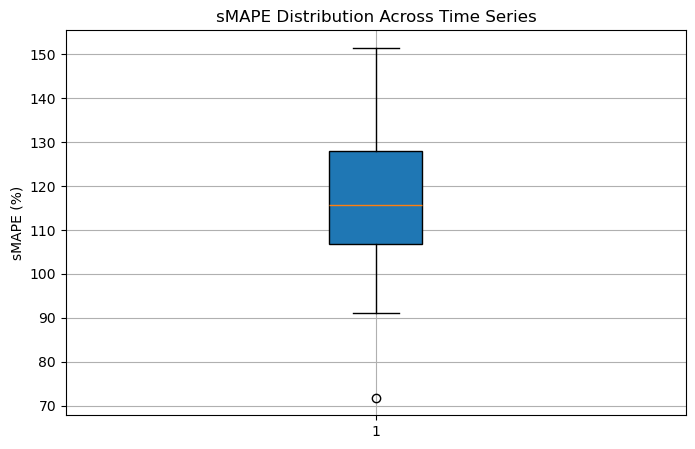

In [28]:
import matplotlib.pyplot as plt

# Create boxplot
plt.figure(figsize=(8, 5))
plt.boxplot(mape_list, vert=True, patch_artist=True)
plt.title("MAPE Distribution Across Time Series")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.boxplot(smape_list, vert=True, patch_artist=True)
plt.title("sMAPE Distribution Across Time Series")
plt.ylabel("sMAPE (%)")
plt.grid(True)
plt.show()

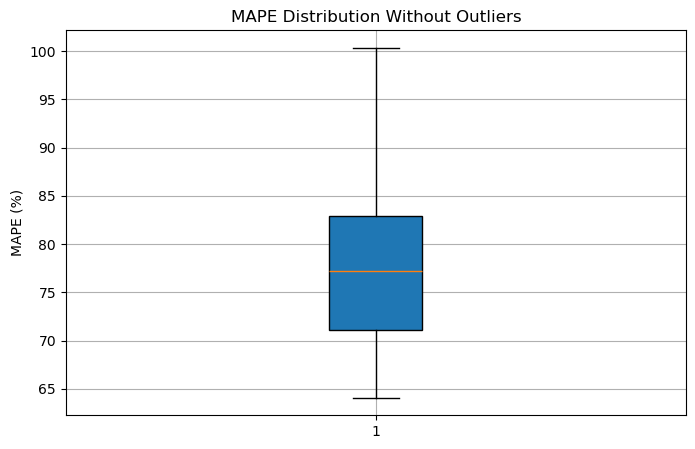

Average MAPE:  77.51447831820364


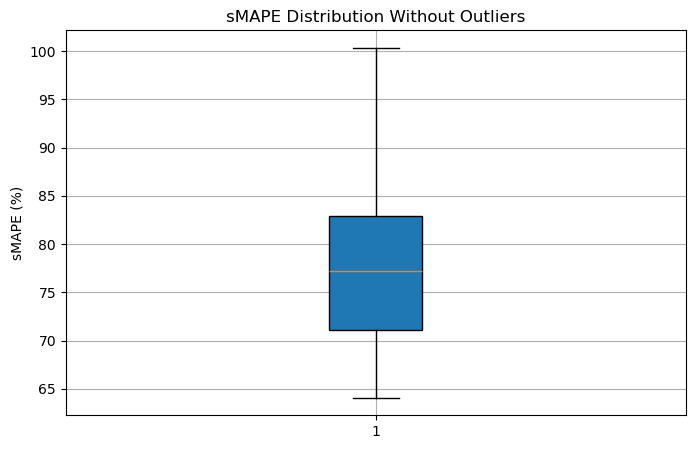

Average sMAPE:  120.29147905047232


In [30]:
mape_array = np.array(mape_list)

# Compute IQR
q1 = np.percentile(mape_array, 25)
q3 = np.percentile(mape_array, 75)
iqr = q3 - q1

# Define bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out outliers
filtered_mape = mape_array[(mape_array >= lower_bound) & (mape_array <= upper_bound)]

# Plot boxplot without outliers
plt.figure(figsize=(8, 5))
plt.boxplot(filtered_mape, patch_artist=True)
plt.title("MAPE Distribution Without Outliers")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.show()

print("Average MAPE: ", np.mean(filtered_mape))


smape_array = np.array(smape_list)

# Compute IQR
q1 = np.percentile(smape_array, 25)
q3 = np.percentile(smape_array, 75)
iqr = q3 - q1

# Define bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out outliers
filtered_smape = smape_array[(smape_array >= lower_bound) & (smape_array <= upper_bound)]

# Plot boxplot without outliers
plt.figure(figsize=(8, 5))
plt.boxplot(filtered_mape, patch_artist=True)
plt.title("sMAPE Distribution Without Outliers")
plt.ylabel("sMAPE (%)")
plt.grid(True)
plt.show()

print("Average sMAPE: ", np.mean(filtered_smape))

In [31]:
predictor.delete_endpoint()

[05/08/25 21:56:09] INFO     Deleting endpoint configuration with name:                             ]8;id=307419;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=869693;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4913\4913]8;;\
                             forecasting-deepar-2025-05-08-21-45-56-870                                            

                    INFO     Deleting endpoint with name:                                           ]8;id=605397;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=201629;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4903\4903]8;;\
                             forecasting-deepar-2025-05-08-21-45-56-870                                            

# Cluster 6

In [12]:
cluster_6_df = formatted_df[formatted_df['Cluster'] ==6]
cluster_6_df

,index,Date,Cluster,ProductId,UnitsSold
81,97548,2009-12-01,6,plasters in tin circus parade,0.0
82,98287,2009-12-01,6,plasters in tin skulls,0.0
83,99026,2009-12-01,6,plasters in tin spaceboy,0.0
84,99765,2009-12-01,6,plasters in tin strongman,0.0
85,100504,2009-12-01,6,plasters in tin vintage paisley,0.0
...,...,...,...,...,...
104882,101981,2011-12-09,6,plasters in tin woodland animals,15.0
104927,71682,2011-12-09,6,wood 2 drawer cabinet white finish,0.0
104928,104937,2011-12-09,6,wood black board ant white finish,2.0
104929,72421,2011-12-09,6,wood s3 cabinet ant white finish,0.0


In [14]:
import pandas as pd
import numpy as np
import json

prediction_length = 30
freq = "D"

train_data = []
test_data = []
future_data = []  # ground truth for evaluation later

# Determine global cutoff date
train_end_date = cluster_6_df["Date"].max() - pd.Timedelta(days=prediction_length)

for product_id, group in cluster_6_df.groupby("ProductId"):
    group = group.sort_values("Date")
    target = group["UnitsSold"].tolist()
    target_log = np.log1p(target)

    start_date = group["Date"].iloc[0]
    split_idx = (group["Date"] <= train_end_date).sum()

    if split_idx >= prediction_length:
        # Train record (no future)
        train_data.append({
            "start": str(start_date.date()),
            "target": target_log[:split_idx],
            "item_id": str(product_id)
        })

        # Test record (for prediction — only up to prediction start)
        test_data.append({
            "start": str(start_date.date()),
            "target": target_log[:split_idx],
            "item_id": str(product_id)
        })

        # Store full target (for evaluation after prediction)
        future_data.append({
            "item_id": str(product_id),
            "actual": target_log[split_idx:split_idx + prediction_length].tolist()
        })


In [15]:
import json

def convert_numpy(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, (np.integer, np.floating)):
        return obj.item()
    return obj

# Save train_series
with open("train.json", "w") as f:
    for record in train_series:
        record_cleaned = json.loads(json.dumps(record, default=convert_numpy))
        f.write(json.dumps(record_cleaned) + "\n")

# Save test_series
with open("test.json", "w") as f:
    for record in test_series:
        record_cleaned = json.loads(json.dumps(record, default=convert_numpy))
        f.write(json.dumps(record_cleaned) + "\n")

with open("actual.json", "w") as f:
    for record in future_data:
        f.write(json.dumps(record) + "\n")

In [16]:
df = pd.read_json("test.json", lines=True)
df

,start,target,item_id
0,2009-12-01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",plasters in tin circus parade
1,2009-12-01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",plasters in tin skulls
2,2009-12-01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",plasters in tin spaceboy
3,2009-12-01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",plasters in tin strongman
4,2009-12-01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",plasters in tin vintage paisley
5,2009-12-01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",plasters in tin woodland animals
6,2009-12-01,"[2.39789527279837, 1.791759469228055, 3.332204...",wood 2 drawer cabinet white finish
7,2009-12-01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",wood black board ant white finish
8,2009-12-01,"[1.791759469228055, 2.39789527279837, 3.295836...",wood s3 cabinet ant white finish
9,2009-12-01,"[3.4339872044851463, 4.430816798843313, 3.8918...",wooden picture frame white finish


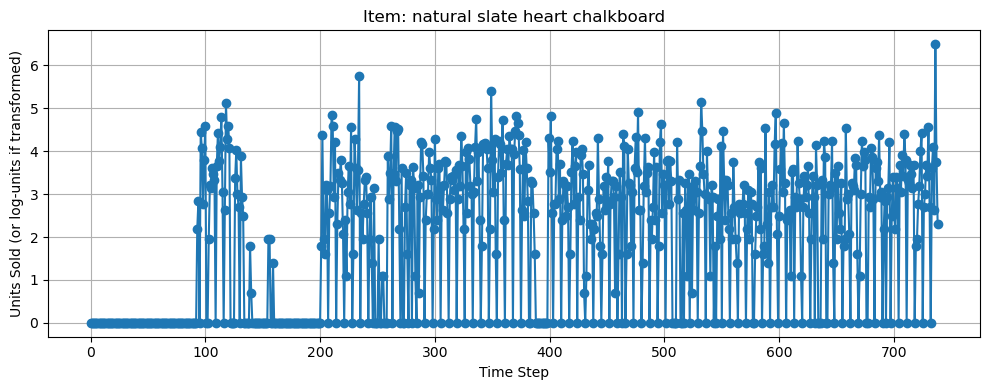

In [68]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume your DataFrame is named `df`
row = df.iloc[2]  # Row 1 (second row)

# Plot the target values
plt.figure(figsize=(10, 4))
plt.plot(row['target'], marker='o')
plt.title(f"Item: {row['item_id']}")
plt.xlabel("Time Step")
plt.ylabel("Units Sold (or log-units if transformed)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [65]:
import json

# Save train_series
with open("train.json", "w") as f:
    for record in train_series:
        f.write(json.dumps(record) + "\n")

# Save test_series
with open("test.json", "w") as f:
    for record in test_series:
        f.write(json.dumps(record) + "\n")

In [41]:
from sagemaker import image_uris, Session
from sagemaker.estimator import Estimator
import sagemaker
from sagemaker.inputs import TrainingInput


role = sagemaker.get_execution_role()
s3 = boto3.client('s3')
bucket = s3_bucket
prefix = 'deepar-retail2'

s3.upload_file('train.json', bucket, f'{prefix}/train/train.json')
s3.upload_file('test.json', bucket, f'{prefix}/test/test.json')

s3_train_path = f's3://{bucket}/{prefix}/train/'
s3_test_path = f's3://{bucket}/{prefix}/test/'

image_uri = image_uris.retrieve(framework='forecasting-deepar', region=sagemaker_session.boto_region_name)

estimator = Estimator(
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type='ml.c4.2xlarge',
    output_path=f's3://{bucket}/{prefix}/output/',
    sagemaker_session=sagemaker_session
) 

# Set hyperparameters
estimator.set_hyperparameters(
    time_freq='D',
    context_length=365,
    prediction_length=30,
    epochs=100,
    early_stopping_patience=5,
    mini_batch_size=64,
    learning_rate=5e-4,
    num_layers=3,
    num_cells=80,
    likelihood="student-t",
    test_quantiles="[0.1, 0.5, 0.9]"
)

# Launch training job
estimator.fit({
    "train": TrainingInput(s3_train_path, content_type="json"),
    "test": TrainingInput(s3_test_path, content_type="json")
})

[05/08/25 22:15:03] INFO     Same images used for training and inference. Defaulting to image     ]8;id=74870;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=638720;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=256702;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=171339;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=671088;file:///opt/conda/lib/python3.12/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=721590;file:///opt/conda/lib/python3.12/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=883794;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=805635;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#1042\1042]8;;\
                             forecasting-deepar-2025-05-08-22-15-03-694                                            

2025-05-08 22:15:05 Starting - Starting the training job...
2025-05-08 22:15:37 Downloading - Downloading input data...
2025-05-08 22:15:53 Downloading - Downloading the training image..................
2025-05-08 22:18:49 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[05/08/2025 22:19:08 INFO 139650610775872] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likeliho

In [17]:

sm = boto3.client('sagemaker')

training_job_name = "forecasting-deepar-2025-05-08-22-15-03-694"
response = sm.describe_training_job(TrainingJobName=training_job_name)
model_artifact = response["ModelArtifacts"]["S3ModelArtifacts"]
print(model_artifact)

s3://sagemaker-us-east-2-153999390800/deepar-retail2/output/forecasting-deepar-2025-05-08-22-15-03-694/output/model.tar.gz


In [20]:
sm = boto3.client('sagemaker')

endpoints = sm.list_endpoints()
for ep in endpoints['Endpoints']:
    print(ep['EndpointName'], ep['EndpointStatus'])


forecasting-deepar-2025-05-10-00-52-27-019 Creating
forecasting-deepar-2025-05-10-00-09-52-807 InService
forecasting-deepar-2025-05-09-23-00-02-006 InService
forecasting-deepar-2025-05-09-02-22-19-388 InService
forecasting-deepar-2025-05-08-22-30-50-836 InService
forecasting-deepar-2025-05-08-16-35-12-509 InService
forecasting-deepar-2025-05-08-04-51-38-026 InService
forecasting-deepar-2025-05-08-02-02-30-684 InService


In [21]:
sm.delete_endpoint(EndpointName='forecasting-deepar-2025-05-08-02-02-30-684')

{'ResponseMetadata': {'RequestId': '363df982-42c4-4300-ab1b-5d43d54f0d57',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '363df982-42c4-4300-ab1b-5d43d54f0d57',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 10 May 2025 00:57:59 GMT',
   'content-length': '0'},
  'RetryAttempts': 0}}

In [22]:
from sagemaker.model import Model

image_uri = image_uris.retrieve("forecasting-deepar", region=region)

model = Model(
    image_uri=image_uri,
    model_data=model_artifact,
    role=role,
    sagemaker_session=sagemaker_session
)

predictor = model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large"
)

[05/10/25 00:58:00] INFO     Same images used for training and inference. Defaulting to image     ]8;id=45561;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=765179;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=396922;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=82627;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating model with name: forecasting-deepar-2025-05-10-00-58-00-247   ]8;id=648564;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=928463;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4094\4094]8;;\

                    INFO     Creating endpoint-config with name                                     ]8;id=738797;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=72933;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#5937\5937]8;;\
                             forecasting-deepar-2025-05-10-00-58-00-977                                            

[05/10/25 00:58:01] INFO     Creating endpoint with name forecasting-deepar-2025-05-10-00-58-00-977 ]8;id=303445;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=83667;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4759\4759]8;;\

-------------!

In [23]:
import json
import numpy as np
from numpy import array

# Load test context data (used as input)
with open("test.json") as f:
    test_data = [json.loads(line) for line in f]

# Load true future values (not used in prediction)
with open("actual.json") as f:
    actual_data = [json.loads(line) for line in f]

# Sanity check: match by index/item_id
assert len(test_data) == len(actual_data)

# Prediction settings
prediction_length = 30
mape_list = []
smape_list = []

for i in range(len(test_data)):
    context_series = test_data[i]
    future_series = actual_data[i]

    # Construct input for SageMaker endpoint
    input_series = {
        "start": context_series["start"],
        "target": context_series["target"]
    }

    payload = {
        "instances": [input_series],
        "configuration": {
            "num_samples": 100,
            "output_types": ["mean", "quantiles", "samples"],
            "quantiles": ["0.5"]
        }
    }

    # Predict
    serialized_input = json.dumps(payload).encode("utf-8")
    response = predictor.predict(
        serialized_input,
        initial_args={"ContentType": "application/json"}
    )
    result = json.loads(response.decode("utf-8"))

    log_forecast = np.array(result["predictions"][0]["quantiles"]["0.5"])
    forecast = np.expm1(log_forecast)
    forecast = np.clip(forecast, 0, None)

    # Actual values
    log_actual = np.array(future_series["actual"])
    actual = np.expm1(log_actual)
    predicted = array(forecast)

    # MAPE
    mask = actual != 0
    if np.any(mask):
        mape = np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100
        mape_list.append(mape)

        # SMAPE
        denominator = (np.abs(actual[mask]) + np.abs(predicted[mask])) / 2
        smape = np.mean(np.abs(predicted[mask] - actual[mask]) / denominator) * 100
        smape_list.append(smape)

        # Naive forecast: mean of recent context (de-log)
        context = np.expm1(context_series["target"])
        naive_forecast = np.ones(prediction_length) * np.mean(context[-prediction_length:])
        naive_mape = np.mean(np.abs((actual[mask] - naive_forecast[mask]) / actual[mask])) * 100
        naive_mape_list.append(naive_mape)

# Summary
print(f"Mean MAPE: {np.mean(mape_list):.2f}%")
print(f"Mean SMAPE: {np.mean(smape_list):.2f}%")

print(f"MAPE range: {min(mape_list):.2f}% to {max(mape_list):.2f}%")
print(f"sMAPE range: {min(smape_list):.2f}% to {max(smape_list):.2f}%")


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:33                                                                                   │
│                                                                                                  │
│   30 │   }                                                                                       │
│   31 │                                                                                           │
│   32 │   serialized_input = json.dumps(payload).encode("utf-8")                                  │
│ ❱ 33 │   response = predictor.predict(                                                           │
│   34 │   │   serialized_input,                                                                   │
│   35 │   │   initial_args={"ContentType": "application/json"}                                    │
│   36 │   )                                                                                       │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'NoneType' object has no attribute 'predict'

In [47]:
print(np.min(mape_list))
max_mape_index = indices[mape_list.index(min(mape_list))]
min_mape_index = indices[mape_list.index(max(mape_list))]
print(min_mape_index)
print(max_mape_index)

43.15624118395466
9
5


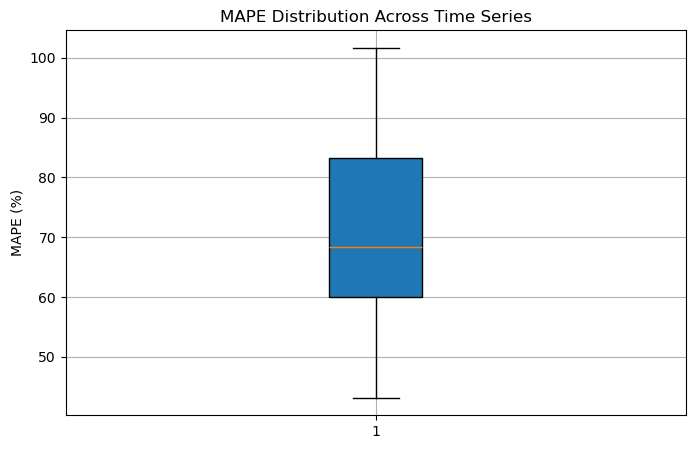

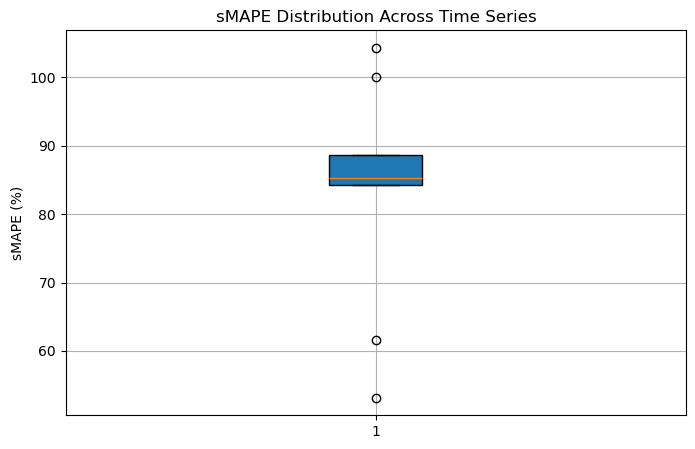

In [45]:
import matplotlib.pyplot as plt

# Create boxplot
plt.figure(figsize=(8, 5))
plt.boxplot(mape_list, vert=True, patch_artist=True)
plt.title("MAPE Distribution Across Time Series")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.boxplot(smape_list, vert=True, patch_artist=True)
plt.title("sMAPE Distribution Across Time Series")
plt.ylabel("sMAPE (%)")
plt.grid(True)
plt.show()

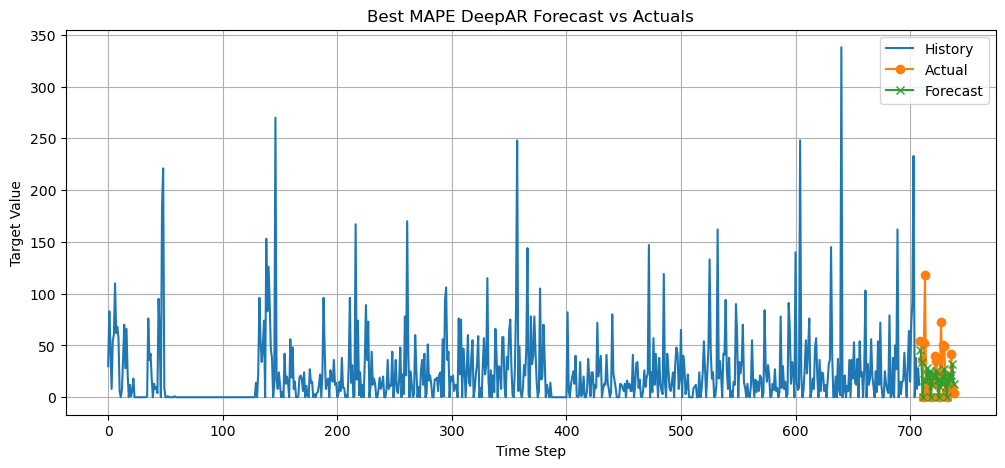

[ 54.  36.   0.  52. 118.   2.   8.  18.  14.   0.  21.  21.  16.  40.
  35.  13.   0.  17.  73.  23.  50.  49.   6.   0.  15.  15.   8.  42.
  10.   4.]
[4.52489598e+01 3.40401140e+01 2.43636142e-02 1.64107171e+01
 1.56733444e+01 1.54791844e+01 2.82148581e+01 2.02017066e+01
 2.54098287e+01 0.00000000e+00 1.17806114e+01 1.96546901e+01
 1.90437267e+01 2.15708373e+01 2.53465734e+01 1.64878269e+01
 0.00000000e+00 1.03511320e+01 1.46756802e+01 1.24464780e+01
 1.96287299e+01 2.70436752e+01 1.68772712e+01 0.00000000e+00
 1.34663383e+01 2.27663357e+01 1.81829879e+01 2.10166245e+01
 3.17947587e+01 1.30164228e+01]


In [46]:
import matplotlib.pyplot as plt
series = data[9].copy()  # or any test example
prediction_length = 30
input_series = {
        "start": series["start"],
        "target": series["target"][:-prediction_length],  # use context window only
    }
payload = {
        "instances": [input_series],
        "configuration": {
            "num_samples": 100,
            "output_types": ["mean", "quantiles", "samples"],
            "quantiles": ["0.5"]
        }
    }

serialized_input = json.dumps(payload).encode("utf-8")
response = predictor.predict(
    serialized_input,
    initial_args={"ContentType": "application/json"}
)
result = json.loads(response.decode("utf-8"))
log_forecast = np.array(result["predictions"][0]["quantiles"]["0.5"])
forecast = np.expm1(log_forecast)
forecast = np.clip(forecast, 0, None)

# Actual values (true future)
log_actual = series["target"][-prediction_length:]
actual = np.expm1(log_actual)

# Historical context

log_history = series["target"][:-prediction_length]
history=np.expm1(log_history)
# Plot
plt.figure(figsize=(12, 5))
plt.plot(range(len(history)), history, label="History")
plt.plot(range(len(history), len(history) + prediction_length), actual, label="Actual", marker='o')
plt.plot(range(len(history), len(history) + prediction_length), forecast, label="Forecast", marker='x')
plt.legend()
plt.title("Best MAPE DeepAR Forecast vs Actuals")
plt.xlabel("Time Step")
plt.ylabel("Target Value")
plt.grid(True)
plt.show()
print(actual)
print(forecast)

# Cluster 12

In [94]:
cluster_12_df = formatted_df[formatted_df['Cluster'] == 12]
cluster_12_df

,index,Date,Cluster,ProductId,UnitsSold
22,13302,2009-12-01,12,door mat fairy cake,28.0
23,87941,2009-12-01,12,door mat fancy font home sweet home,0.0
24,14041,2009-12-01,12,door mat new england,9.0
25,88680,2009-12-01,12,door mat spotty home sweet home,0.0
26,79812,2009-12-01,12,door mat union flag,0.0
...,...,...,...,...,...
104819,88679,2011-12-09,12,door mat fancy font home sweet home,11.0
104820,14779,2011-12-09,12,door mat new england,3.0
104821,89418,2011-12-09,12,door mat spotty home sweet home,0.0
104822,80550,2011-12-09,12,door mat union flag,11.0


In [95]:
import pandas as pd
import numpy as np
import json

prediction_length = 30
freq = "D"

train_data = []
test_data = []
future_data = []  # ground truth for evaluation later

# Determine global cutoff date
train_end_date = cluster_12_df["Date"].max() - pd.Timedelta(days=prediction_length)

for product_id, group in cluster_12_df.groupby("ProductId"):
    group = group.sort_values("Date")
    target = group["UnitsSold"].tolist()
    target_log = np.log1p(target)

    start_date = group["Date"].iloc[0]
    split_idx = (group["Date"] <= train_end_date).sum()

    if split_idx >= prediction_length:
        # Train record (no future)
        train_data.append({
            "start": str(start_date.date()),
            "target": target_log[:split_idx],
            "item_id": str(product_id)
        })

        # Test record (for prediction — only up to prediction start)
        test_data.append({
            "start": str(start_date.date()),
            "target": target_log[:split_idx],
            "item_id": str(product_id)
        })

        # Store full target (for evaluation after prediction)
        future_data.append({
            "item_id": str(product_id),
            "actual": target_log[split_idx:split_idx + prediction_length].tolist()
        })


In [96]:
import json

# Save train_series
with open("train.json", "w") as f:
    for record in train_series:
        f.write(json.dumps(record) + "\n")

# Save test_series
with open("test.json", "w") as f:
    for record in test_series:
        f.write(json.dumps(record) + "\n")

with open("actual.json", "w") as f:
    for record in future_data:
        f.write(json.dumps(record) + "\n")

In [97]:
df = pd.read_json("test.json", lines=True)
df

,start,target,item_id
0,2009-12-01,"[3.367295829986473, 1.0986122886681091, 2.7080...",door mat fairy cake
1,2009-12-01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",door mat fancy font home sweet home
2,2009-12-01,"[2.302585092994045, 2.639057329615258, 3.21887...",door mat new england
3,2009-12-01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",door mat spotty home sweet home
4,2009-12-01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",door mat union flag
5,2009-12-01,"[2.302585092994045, 1.0986122886681091, 1.0986...",doormat hearts


In [52]:
from sagemaker import image_uris, Session
from sagemaker.estimator import Estimator
import sagemaker
from sagemaker.inputs import TrainingInput


role = sagemaker.get_execution_role()
s3 = boto3.client('s3')
bucket = s3_bucket
prefix = 'deepar-retail2'

s3.upload_file('train.json', bucket, f'{prefix}/train/train.json')
s3.upload_file('test.json', bucket, f'{prefix}/test/test.json')

s3_train_path = f's3://{bucket}/{prefix}/train/'
s3_test_path = f's3://{bucket}/{prefix}/test/'

image_uri = image_uris.retrieve(framework='forecasting-deepar', region=sagemaker_session.boto_region_name)

estimator = Estimator(
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type='ml.c4.2xlarge',
    output_path=f's3://{bucket}/{prefix}/output/',
    sagemaker_session=sagemaker_session
) 

# Set hyperparameters
estimator.set_hyperparameters(
    time_freq='D',
    context_length=365,
    prediction_length=30,
    epochs=100,
    early_stopping_patience=5,
    mini_batch_size=64,
    learning_rate=5e-4,
    num_layers=3,
    num_cells=80,
    likelihood="student-t",
    test_quantiles="[0.1, 0.5, 0.9]"
)

# Launch training job
estimator.fit({
    "train": TrainingInput(s3_train_path, content_type="json"),
    "test": TrainingInput(s3_test_path, content_type="json")
})

[05/08/25 22:53:42] INFO     Same images used for training and inference. Defaulting to image     ]8;id=958972;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=674079;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=258607;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=781177;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=612982;file:///opt/conda/lib/python3.12/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=449245;file:///opt/conda/lib/python3.12/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=229974;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=145051;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#1042\1042]8;;\
                             forecasting-deepar-2025-05-08-22-53-42-837                                            

2025-05-08 22:53:47 Starting - Starting the training job...
2025-05-08 22:54:01 Starting - Preparing the instances for training...
2025-05-08 22:54:35 Downloading - Downloading the training image..................
2025-05-08 22:57:27 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[05/08/2025 22:57:44 INFO 140103193356096] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001',

In [54]:
sm = boto3.client('sagemaker')

endpoints = sm.list_endpoints()
for ep in endpoints['Endpoints']:
    print(ep['EndpointName'], ep['EndpointStatus'])

forecasting-deepar-2025-05-08-22-30-50-836 InService
forecasting-deepar-2025-05-08-16-35-12-509 InService
forecasting-deepar-2025-05-08-04-51-38-026 InService
forecasting-deepar-2025-05-08-02-02-30-684 InService
forecasting-deepar-2025-05-08-01-35-52-240 InService
forecasting-deepar-2025-05-07-23-20-29-536 InService
forecasting-deepar-2025-05-07-22-49-37-820 InService
forecasting-deepar-2025-05-07-22-18-50-539 InService


In [55]:
sm.delete_endpoint(EndpointName='forecasting-deepar-2025-05-07-22-18-50-539')


{'ResponseMetadata': {'RequestId': '33708de3-1da4-4ac8-8815-07a8caddcb82',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '33708de3-1da4-4ac8-8815-07a8caddcb82',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 08 May 2025 23:07:55 GMT',
   'content-length': '0'},
  'RetryAttempts': 0}}

In [56]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large"
)

[05/08/25 23:07:56] INFO     Creating model with name: forecasting-deepar-2025-05-08-23-07-56-817   ]8;id=927767;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=563054;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4094\4094]8;;\

[05/08/25 23:07:57] INFO     Creating endpoint-config with name                                     ]8;id=356699;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=116970;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#5937\5937]8;;\
                             forecasting-deepar-2025-05-08-23-07-56-817                                            

                    INFO     Creating endpoint with name forecasting-deepar-2025-05-08-23-07-56-817 ]8;id=3402;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=757168;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4759\4759]8;;\

-------------!

In [57]:
import json
import numpy as np
from numpy import array

# Load test context data (used as input)
with open("test.json") as f:
    test_data = [json.loads(line) for line in f]

# Load true future values (not used in prediction)
with open("actual.json") as f:
    actual_data = [json.loads(line) for line in f]

# Sanity check: match by index/item_id
assert len(test_data) == len(actual_data)

# Prediction settings
prediction_length = 30
mape_list = []
smape_list = []

for i in range(len(test_data)):
    context_series = test_data[i]
    future_series = actual_data[i]

    # Construct input for SageMaker endpoint
    input_series = {
        "start": context_series["start"],
        "target": context_series["target"]
    }

    payload = {
        "instances": [input_series],
        "configuration": {
            "num_samples": 100,
            "output_types": ["mean", "quantiles", "samples"],
            "quantiles": ["0.5"]
        }
    }

    # Predict
    serialized_input = json.dumps(payload).encode("utf-8")
    response = predictor.predict(
        serialized_input,
        initial_args={"ContentType": "application/json"}
    )
    result = json.loads(response.decode("utf-8"))

    log_forecast = np.array(result["predictions"][0]["quantiles"]["0.5"])
    forecast = np.expm1(log_forecast)
    forecast = np.clip(forecast, 0, None)

    # Actual values
    log_actual = np.array(future_series["actual"])
    actual = np.expm1(log_actual)
    predicted = array(forecast)

    # MAPE
    mask = actual != 0
    if np.any(mask):
        mape = np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100
        mape_list.append(mape)

        # SMAPE
        denominator = (np.abs(actual[mask]) + np.abs(predicted[mask])) / 2
        smape = np.mean(np.abs(predicted[mask] - actual[mask]) / denominator) * 100
        smape_list.append(smape)

        # Naive forecast: mean of recent context (de-log)
        context = np.expm1(context_series["target"])
        naive_forecast = np.ones(prediction_length) * np.mean(context[-prediction_length:])
        naive_mape = np.mean(np.abs((actual[mask] - naive_forecast[mask]) / actual[mask])) * 100
        naive_mape_list.append(naive_mape)

# Summary
print(f"Mean MAPE: {np.mean(mape_list):.2f}%")
print(f"Mean SMAPE: {np.mean(smape_list):.2f}%")

print(f"MAPE range: {min(mape_list):.2f}% to {max(mape_list):.2f}%")


Mean MAPE: 68.56%
Mean SMAPE: 87.20%
MAPE range: 56.15% to 94.52%


In [58]:
max_mape_index = indices[mape_list.index(min(mape_list))]
min_mape_index = indices[mape_list.index(max(mape_list))]
print(min_mape_index)
print(max_mape_index)

1
2


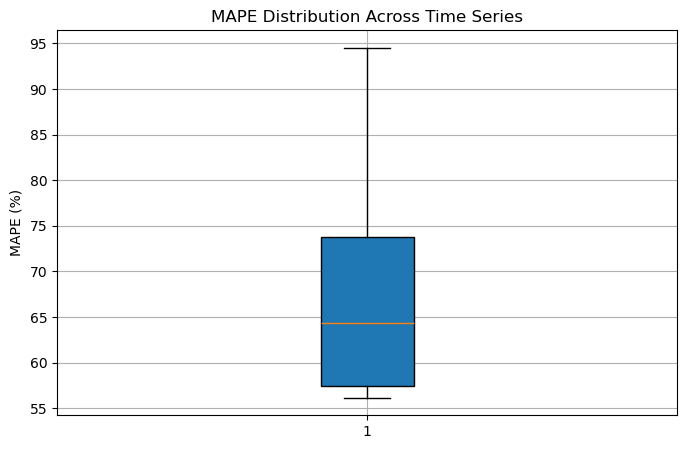

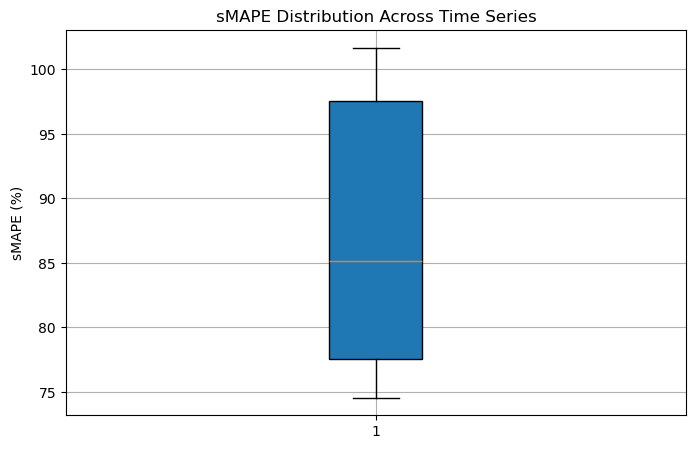

In [59]:
import matplotlib.pyplot as plt

# Create boxplot
plt.figure(figsize=(8, 5))
plt.boxplot(mape_list, vert=True, patch_artist=True)
plt.title("MAPE Distribution Across Time Series")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.boxplot(smape_list, vert=True, patch_artist=True)
plt.title("sMAPE Distribution Across Time Series")
plt.ylabel("sMAPE (%)")
plt.grid(True)
plt.show()

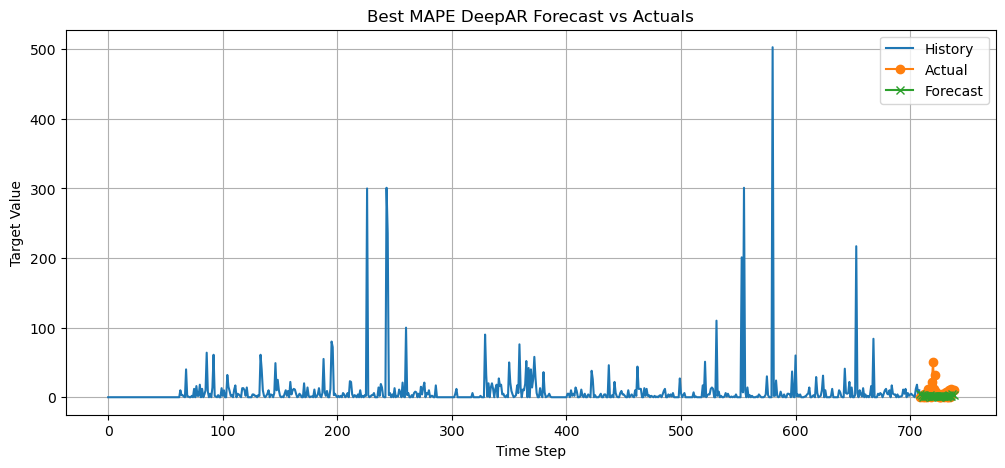

[ 1.  2.  0.  4.  0.  5.  1. 12.  6.  0. 22. 50. 12. 32.  8.  2.  0.  0.
  1.  5.  5.  0.  7.  0.  1. 11.  1. 12.  9. 11.]
[4.74766452 3.41206649 0.01462813 2.85788273 2.15064467 1.69038302
 2.25234917 1.97454932 3.17556287 0.04825287 1.45874879 1.40600992
 1.8856621  1.60667096 2.13043637 2.35170789 0.         1.22127192
 1.72770351 1.527072   2.02193522 1.73838629 2.04323362 0.16807442
 2.14154761 2.75045036 2.31928207 2.20953827 4.53375281 2.61097775]


In [60]:
import matplotlib.pyplot as plt
series = data[1].copy()  # or any test example
prediction_length = 30
input_series = {
        "start": series["start"],
        "target": series["target"][:-prediction_length],  # use context window only
    }
payload = {
        "instances": [input_series],
        "configuration": {
            "num_samples": 100,
            "output_types": ["mean", "quantiles", "samples"],
            "quantiles": ["0.5"]
        }
    }

serialized_input = json.dumps(payload).encode("utf-8")
response = predictor.predict(
    serialized_input,
    initial_args={"ContentType": "application/json"}
)
result = json.loads(response.decode("utf-8"))
log_forecast = np.array(result["predictions"][0]["quantiles"]["0.5"])
forecast = np.expm1(log_forecast)
forecast = np.clip(forecast, 0, None)

# Actual values (true future)
log_actual = series["target"][-prediction_length:]
actual = np.expm1(log_actual)

# Historical context

log_history = series["target"][:-prediction_length]
history=np.expm1(log_history)
# Plot
plt.figure(figsize=(12, 5))
plt.plot(range(len(history)), history, label="History")
plt.plot(range(len(history), len(history) + prediction_length), actual, label="Actual", marker='o')
plt.plot(range(len(history), len(history) + prediction_length), forecast, label="Forecast", marker='x')
plt.legend()
plt.title("Best MAPE DeepAR Forecast vs Actuals")
plt.xlabel("Time Step")
plt.ylabel("Target Value")
plt.grid(True)
plt.show()
print(actual)
print(forecast)

In [61]:
predictor.delete_endpoint()


[05/08/25 23:22:00] INFO     Deleting endpoint configuration with name:                             ]8;id=798975;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=187330;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4913\4913]8;;\
                             forecasting-deepar-2025-05-08-23-07-56-817                                            

                    INFO     Deleting endpoint with name:                                           ]8;id=655674;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=312942;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4903\4903]8;;\
                             forecasting-deepar-2025-05-08-23-07-56-817                                            